# Pré processamento

In [121]:
# Importando as bibliotecas e construindo o dataframe
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import faiss
import random
from sklearn.impute import KNNImputer
from sentence_transformers import SentenceTransformer
from statistics import mean

In [ ]:
# concatenando dois dataframes (um com fake news e outro com noticias verdadeiras)
fake_df = pd.read_csv('https://raw.githubusercontent.com/guilopesrbc/fake_news_detector/main/Fake.csv')
true_df = pd.read_csv('https://raw.githubusercontent.com/guilopesrbc/fake_news_detector/main/True.csv')
# adicionando coluna label, correspondente a veracidade da noticias (1 para verdadeiro e 0 para falsa)
fake_df['label'] = 0
true_df['label'] = 1

combined_df = pd.concat([fake_df, true_df], ignore_index=True)

combined_df.to_csv('Combined.csv', index=False)
combined_df.reset_index(drop=True,inplace=True)
combined_df.head()

# Criando coluna num_of_words correspondente ao número de palavras presentes no texto da noticia

In [ ]:
# criando coluna num_of_words correspondente ao número de palavras presentes no texto da noticia
import re
# regex para substituir caracteres que não forem letras e números
regex = r'[^a-zA-Z0-9\s]'
combined_df['text'] = combined_df['text'].map(lambda x: re.sub(regex, '', x))
combined_df['num_of_words'] = combined_df['text'].map(lambda x: len(x.split()))

# Criando nova coluna com texto vetorizado 

In [ ]:
# Initialize the Sentence Transformer model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Function to vectorize the text
def vectorize_text(text):
    return model.encode(text)

# Apply the function to create a new column with vectorized text
combined_df['text_vector'] = combined_df['text'].map(vectorize_text)
combined_df.to_csv('vectorized_texts.csv', index=False)

# Reading from csv file 

In [68]:
# Função para converter strings de vetores em numpy arrays de forma segura
def str_to_array(vector_str):
    try:
        # Remover caracteres desnecessários e converter a string para um numpy array
        cleaned_str = vector_str.replace('\n', '').replace('[', '').replace(']', '').replace('  ', ' ')
        return np.fromstring(cleaned_str, sep=' ')
    except Exception as e:
        print(f"Error converting string to array: {e}")
        return np.nan

def convert_text_vectors_from_str_to_np_arr():
    # Certifique-se de que os vetores de texto sejam numpy arrays, não strings
    df['text_vector'] = df['text_vector'].map(str_to_array) if isinstance(df['text_vector'][0], str) else df['text_vector']

    # Verifique se todos os vetores têm o mesmo tamanho
    vector_length = len(df['text_vector'][0])
    df['text_vector'] = df['text_vector'].map(lambda x: x if len(x) == vector_length else np.nan).dropna()

In [69]:
combined_df = pd.read_csv('vectorized.csv')
df = combined_df
convert_text_vectors_from_str_to_np_arr()
combined_df.head()

,title,text,subject,date,label,num_of_words,text_vector
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0,492,"[-0.08635634, 0.16764247, 0.40040964, -0.36150..."
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0,305,"[0.00671101, 0.0081033, -0.20852128, -0.087897..."
2,Sheriff David Clarke Becomes An Internet Joke...,On Friday it was revealed that former Milwauke...,News,"December 30, 2017",0,579,"[-0.362045884, -0.123025492, -0.551379442, -0...."
3,Trump Is So Obsessed He Even Has Obama’s Name...,On Christmas day Donald Trump announced that h...,News,"December 29, 2017",0,441,"[0.0173586905, 0.00204306096, 0.0736115128, 0...."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0,420,"[-0.079019241, 0.473764718, 0.155274183, -0.05..."


# Setando campos como categóricos

In [70]:
combined_df.dtypes

title           object
text            object
subject         object
date            object
label            int64
num_of_words     int64
text_vector     object
dtype: object

In [71]:
combined_df['subject'] = combined_df['subject'].astype('category')

In [72]:
combined_df.dtypes

title             object
text              object
subject         category
date              object
label              int64
num_of_words       int64
text_vector       object
dtype: object

In [73]:
combined_df['num_subjects'] = combined_df['subject'].cat.codes

In [74]:
combined_df.dtypes

title             object
text              object
subject         category
date              object
label              int64
num_of_words       int64
text_vector       object
num_subjects        int8
dtype: object

# Verificando valores nulos e vazios

In [75]:
# verificando valores nulo
combined_df.isnull().sum()

title           0
text            0
subject         0
date            0
label           0
num_of_words    0
text_vector     0
num_subjects    0
dtype: int64

In [76]:
# verificando valores vazios de titulo
remove_spaces = lambda x: ''.join(x.split()) if type(x) == str else x
empty_values = combined_df.map(remove_spaces)
empty_values['title'] = empty_values['title'] == ''
len(empty_values[empty_values['title'] == True])

0

In [77]:
# verificando valores vazios de texto
remove_spaces = lambda x: ''.join(x.split()) if type(x) == str else x
empty_values = combined_df.map(remove_spaces)
empty_values['text'] = empty_values['text'] == ''
len(empty_values[empty_values['text'] == True])

631

In [78]:
# verificando valores vazios de tipo de conteúdo
remove_spaces = lambda x: ''.join(x.split()) if type(x) == str else x
empty_values = combined_df.map(remove_spaces)
empty_values['subject'] = empty_values['subject'] == ''
len(empty_values[empty_values['subject'] == True])

0

In [79]:
# setando valores num_of_words iguais a 0 para nulo
df = combined_df
df['num_of_words'] = df['num_of_words'].map(lambda x: np.nan if x == 0 else x)
df['num_of_words'].isnull().sum()

631

# Dividindo o dataset em batches para otimizar o uso do algoritmo KNN  

In [80]:
batch_size = 5000
df_numpy = df.to_numpy()

# Embaralhar os dados,
np.random.shuffle(df_numpy)
# Dividir o dataset em batches,
n_batches = int(np.ceil(df_numpy.shape[0] / batch_size))  # Número de batches
batches = np.array_split(df_numpy, n_batches)
batches_df = [pd.DataFrame(batch, columns=df.columns) for batch in batches]
df = pd.DataFrame(df_numpy, columns=df.columns)

for batch in batches_df:
    print(batch.isnull().sum())

title            0
text             0
subject          0
date             0
label            0
num_of_words    55
text_vector      0
num_subjects     0
dtype: int64
title            0
text             0
subject          0
date             0
label            0
num_of_words    62
text_vector      0
num_subjects     0
dtype: int64
title            0
text             0
subject          0
date             0
label            0
num_of_words    68
text_vector      0
num_subjects     0
dtype: int64
title            0
text             0
subject          0
date             0
label            0
num_of_words    74
text_vector      0
num_subjects     0
dtype: int64
title            0
text             0
subject          0
date             0
label            0
num_of_words    78
text_vector      0
num_subjects     0
dtype: int64
title            0
text             0
subject          0
date             0
label            0
num_of_words    66
text_vector      0
num_subjects     0
dtype: int64
title     

In [81]:
imputer = KNNImputer(n_neighbors=3)
df_num_of_words_knn = [pd.DataFrame(imputer.fit_transform(batch[['num_subjects', 'num_of_words', 'label']]), columns=df[['num_subjects', 'num_of_words', 'label']].columns) for batch in batches_df]


In [82]:
df_concatened = pd.DataFrame()
for batch in df_num_of_words_knn:
    df_concatened = pd.concat([df_concatened, batch], ignore_index=True)
    print(batch.isnull().sum())

num_subjects    0
num_of_words    0
label           0
dtype: int64
num_subjects    0
num_of_words    0
label           0
dtype: int64
num_subjects    0
num_of_words    0
label           0
dtype: int64
num_subjects    0
num_of_words    0
label           0
dtype: int64
num_subjects    0
num_of_words    0
label           0
dtype: int64
num_subjects    0
num_of_words    0
label           0
dtype: int64
num_subjects    0
num_of_words    0
label           0
dtype: int64
num_subjects    0
num_of_words    0
label           0
dtype: int64
num_subjects    0
num_of_words    0
label           0
dtype: int64


In [83]:
df['num_of_words'] = df_concatened['num_of_words']
df.isnull().sum()

title           0
text            0
subject         0
date            0
label           0
num_of_words    0
text_vector     0
num_subjects    0
dtype: int64

# Normalização

In [84]:
df

,title,text,subject,date,label,num_of_words,text_vector,num_subjects
0,BOOM! DONALD TRUMP HAMMERS BERNIE SANDERS WITH...,Bernie Sanders can t effectively handle two lo...,left-news,"Aug 24, 2015",0,65.0,"[-0.05766127, -0.08229423, -0.47802344, -0.115...",4
1,"Austria will stay pro-European, election victo...",BRUSSELS Reuters Austria s likely next chance...,worldnews,"October 19, 2017",1,294.0,"[-0.03438837, 0.29156557, -0.17497562, -0.0949...",7
2,"Zimbabwe's top general ready ""to step in"" to e...",HARARE Reuters Zimbabwe s top general warned ...,worldnews,"November 13, 2017",1,523.0,"[-0.255922377, 0.441673011, 0.128997251, -0.17...",7
3,Red Cross Federation chief vows corruption cra...,GENEVA Reuters The new president of the world...,worldnews,"November 7, 2017",1,316.0,"[-0.05711896, 0.35245728, -0.37331748, -0.2392...",7
4,WATCH: Giuliani Says A Woman Can’t Be Preside...,Rudy Giuliani not only insulted the intelligen...,News,"October 2, 2016",0,724.0,"[-0.157160923, 0.253624171, 0.105078742, 0.316...",2
...,...,...,...,...,...,...,...,...
44893,Venezuelans face growing queues to buy gasoline,PUERTO ORDAZ Venezuela Reuters Venezuelan dri...,worldnews,"September 21, 2017",1,465.0,"[-0.20967855, -0.10863805, -0.06991965, 0.2554...",7
44894,SHOCKING ACT OF “TOLERANCE”: TRANSGENDER THUG ...,Transgender activist and bully Hanna Zoey Tur ...,left-news,"Jul 17, 2015",0,45.0,"[0.16544178, -0.07164668, -0.40392208, 0.24336...",4
44895,U.N. special envoy on Syria says had 'useful' ...,MOSCOW Reuters United Nations special envoy o...,worldnews,"November 24, 2017",1,63.0,"[0.27024585, 0.420697957, -0.117045283, 0.1418...",7
44896,BRAINWASHED CHILDREN MOCK President Trump in D...,A disturbing video published by The Washington...,politics,"Jul 3, 2017",0,259.0,"[-0.0039392, -0.19550677, -0.30443633, -0.3015...",5


In [85]:
# nomarlizando entre 0 e 1 min-max usando scikit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
df['subject_norm'] = scaler.fit_transform(df[['num_subjects']])
df['num_of_words_norm'] = scaler.fit_transform(df[['num_of_words']])
df.head()

,title,text,subject,date,label,num_of_words,text_vector,num_subjects,subject_norm,num_of_words_norm
0,BOOM! DONALD TRUMP HAMMERS BERNIE SANDERS WITH...,Bernie Sanders can t effectively handle two lo...,left-news,"Aug 24, 2015",0,65.0,"[-0.05766127, -0.08229423, -0.47802344, -0.115...",4,0.571429,0.007881
1,"Austria will stay pro-European, election victo...",BRUSSELS Reuters Austria s likely next chance...,worldnews,"October 19, 2017",1,294.0,"[-0.03438837, 0.29156557, -0.17497562, -0.0949...",7,1.000000,0.036079
2,"Zimbabwe's top general ready ""to step in"" to e...",HARARE Reuters Zimbabwe s top general warned ...,worldnews,"November 13, 2017",1,523.0,"[-0.255922377, 0.441673011, 0.128997251, -0.17...",7,1.000000,0.064278
3,Red Cross Federation chief vows corruption cra...,GENEVA Reuters The new president of the world...,worldnews,"November 7, 2017",1,316.0,"[-0.05711896, 0.35245728, -0.37331748, -0.2392...",7,1.000000,0.038788
4,WATCH: Giuliani Says A Woman Can’t Be Preside...,Rudy Giuliani not only insulted the intelligen...,News,"October 2, 2016",0,724.0,"[-0.157160923, 0.253624171, 0.105078742, 0.316...",2,0.285714,0.089028


In [86]:
df['subject_norm'].describe()

count    44898.000000
mean         0.674274
std          0.293159
min          0.000000
25%          0.285714
50%          0.714286
75%          0.857143
max          1.000000
Name: subject_norm, dtype: float64

In [87]:
df['num_of_words_norm'].describe()

count    44898.000000
mean         0.050478
std          0.042893
min          0.000000
25%          0.026228
50%          0.044822
75%          0.063416
max          1.000000
Name: num_of_words_norm, dtype: float64

# Discretização

In [88]:
# discretizando com 10 bins com mesmo intervalo
df['num_of_words_dist'] = pd.cut(df['num_of_words'], 10)

In [89]:
df['num_of_words_dist'].value_counts()

num_of_words_dist
(-7.121, 813.1]     41508
(813.1, 1625.2]      3028
(1625.2, 2437.3]      201
(2437.3, 3249.4]       76
(3249.4, 4061.5]       44
(4061.5, 4873.6]       13
(4873.6, 5685.7]       12
(5685.7, 6497.8]        6
(6497.8, 7309.9]        6
(7309.9, 8122.0]        4
Name: count, dtype: int64

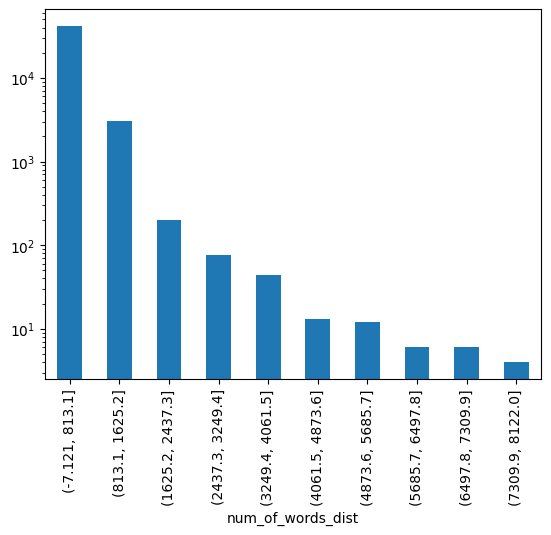

In [90]:
df['num_of_words_dist'].value_counts().plot(kind="bar")
plt.yscale("log")

# Detecção de outliers

In [91]:
df_without_text_vectors = df.drop(columns=['text_vector'])
duplicates = df[df_without_text_vectors.duplicated()]
duplicates.head()

,title,text,subject,date,label,num_of_words,text_vector,num_subjects,subject_norm,num_of_words_norm,num_of_words_dist
3508,Britain preparing to transfer 400 million poun...,LONDON Reuters Britain is preparing to transf...,worldnews,"November 16, 2017",1,147.0,"[0.06184462, -0.09861609, -0.20703124, -0.1311...",7,1.0,0.017978,"(-7.121, 813.1]"
4459,Libya considering UK extradition request for M...,TRIPOLI Reuters Libyan authorities are proces...,worldnews,"November 2, 2017",1,465.0,"[-0.0966399908, 0.192807794, 0.0508902334, -0....",7,1.0,0.057136,"(-7.121, 813.1]"
4825,Philippine police chief defends deadly drug wa...,MANILA Reuters The police chief of the Philip...,worldnews,"December 20, 2017",1,607.0,"[0.0119605586, 0.210904554, 0.0373840332, 0.13...",7,1.0,0.074621,"(-7.121, 813.1]"
5468,Islamic State claims air base attack in Egypt'...,CAIRO Reuters Islamic State has claimed an at...,worldnews,"December 20, 2017",1,187.0,"[-0.0794286355, 0.383361816, -0.289002925, -0....",7,1.0,0.022904,"(-7.121, 813.1]"
5741,U.S. creating 'sensational hype' over China's ...,BEIJING Reuters The United States has created...,worldnews,"December 21, 2017",1,360.0,"[-0.21992368, -0.17033483, -0.15842369, -0.240...",7,1.0,0.044206,"(-7.121, 813.1]"


In [92]:
duplicates_mask = df_without_text_vectors.duplicated(keep=False)

# Drop duplicates from the original DataFrame
df = df[~duplicates_mask]

In [93]:
duplicates = df[df_without_text_vectors.duplicated()]
duplicates.head()

/var/folders/wz/qw2ddg4n5xxgzdh4w5yt3ztr0000gn/T/ipykernel_85577/4099902805.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  duplicates = df[df_without_text_vectors.duplicated()]


,title,text,subject,date,label,num_of_words,text_vector,num_subjects,subject_norm,num_of_words_norm,num_of_words_dist


<Axes: >

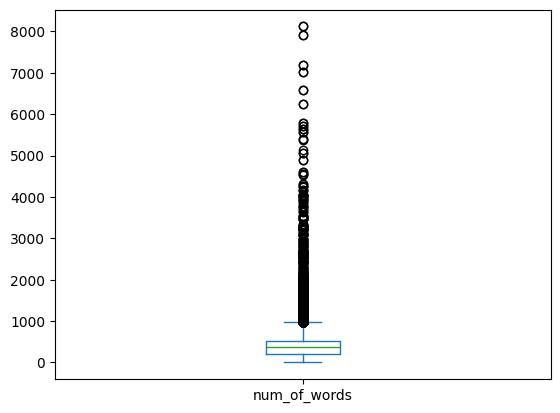

In [94]:
df['num_of_words'].plot.box()

<Axes: ylabel='Frequency'>

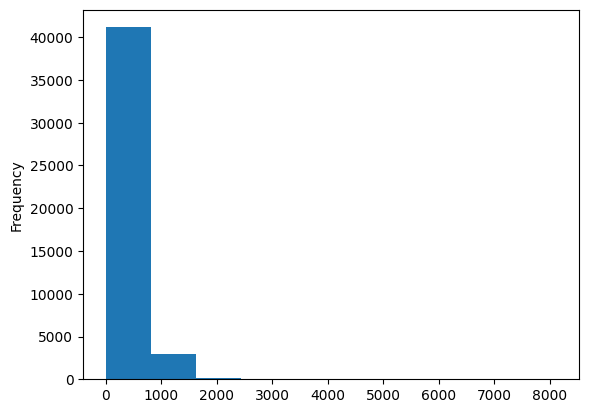

In [95]:
df['num_of_words'].plot.hist()

/var/folders/wz/qw2ddg4n5xxgzdh4w5yt3ztr0000gn/T/ipykernel_85577/1135887764.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_num_of_words'] = np.log10(df['num_of_words'])


<Axes: ylabel='Frequency'>

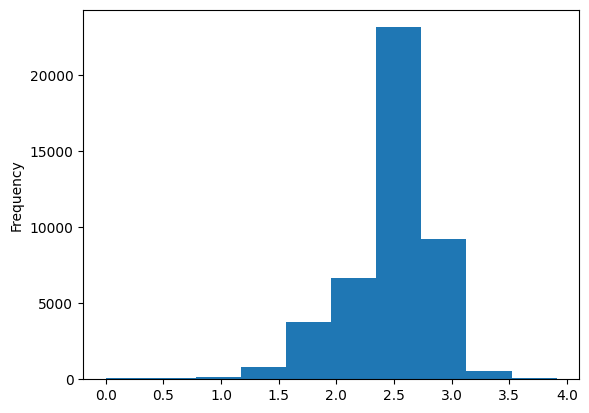

In [96]:
df['log_num_of_words'] = np.log10(df['num_of_words'])
df['log_num_of_words'].plot.hist()

In [97]:
mad = np.abs(df['log_num_of_words'] - df['log_num_of_words'].median()).median()*(1/0.6745)
print(mad)

0.26460711412311866


<Axes: >

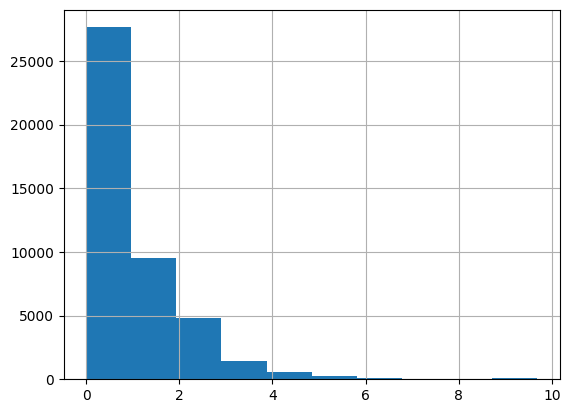

In [98]:
(np.abs(df['log_num_of_words']-df['log_num_of_words'].median())/mad).hist()

In [99]:
df[np.abs(df['log_num_of_words']-df['log_num_of_words'].median())/mad > 3.5]

,title,text,subject,date,label,num_of_words,text_vector,num_subjects,subject_norm,num_of_words_norm,num_of_words_dist,log_num_of_words
38,AUDIENCE MEMBER GETS The Last Word When Michae...,Michael Moore Trump is a malignant narcissist...,politics,"Dec 7, 2016",0,20.0,"[0.148010686, -0.61836952, -0.102962993, -0.20...",5,0.714286,0.002340,"(-7.121, 813.1]",1.301030
56,OH BOY! Obamacare Architect Ripped To Shreds B...,HERE S A REMINDER OF JONATHAN GRUBER INSULTING...,Government News,"Nov 16, 2016",0,14.0,"[-0.333420336, 0.217102319, -0.185746655, -0.3...",0,0.000000,0.001601,"(-7.121, 813.1]",1.146128
64,Lockheed Martin wins $1.45 billion contract fo...,WASHINGTON Reuters Lockheed Martin Corp has b...,politicsNews,"December 22, 2016",1,43.0,"[-0.2877301, 0.1986276, -0.2192152, -0.1745365...",6,0.857143,0.005172,"(-7.121, 813.1]",1.633468
186,WHOA! ANDERSON COOPER GOT MORE Than He Bargain...,Melania Trump is pure class She refuses to all...,politics,"Oct 20, 2016",0,28.0,"[0.29589358, -0.109288268, -0.0126214325, 0.11...",5,0.714286,0.003325,"(-7.121, 813.1]",1.447158
203,WATCH Obama Mention Himself 119 Times During H...,Narcissist isn t a strong enough word to descr...,left-news,"Jul 28, 2016",0,13.0,"[-0.160895452, -0.0544331931, -0.272669584, -0...",4,0.571429,0.001478,"(-7.121, 813.1]",1.113943
...,...,...,...,...,...,...,...,...,...,...,...,...
44728,WATCH: Black Pastors Come On Stage And Endorse...,A Virginia rally for Donald Trump turned into ...,politics,"Dec 3, 2015",0,16.0,"[-0.176784828, 0.313457549, -0.227736637, 0.50...",5,0.714286,0.001847,"(-7.121, 813.1]",1.204120
44762,KELLYANNE CONWAY Hits Back On Claims Russia Ha...,Not fake news just fake Team Trump hits back...,politics,"Jan 11, 2017",0,24.0,"[-0.400914431, -0.105775014, -0.667877853, -0....",5,0.714286,0.002832,"(-7.121, 813.1]",1.380211
44791,WOW! PASTOR MARK BURNS Delivers Three Great Wo...,Pastor Mark Burns is such a fantastic speaker ...,politics,"Jul 21, 2016",0,24.0,"[-0.122208416, 0.0949808657, -0.240803346, -0....",5,0.714286,0.002832,"(-7.121, 813.1]",1.380211
44809,"Kremlin says to defend rights of Kerimov, busi...",MOSCOW Reuters Kremlin spokesman Dmitry Pesko...,worldnews,"December 15, 2017",1,34.0,"[-0.372339159, 0.616591454, -0.616333008, -0.2...",7,1.000000,0.004064,"(-7.121, 813.1]",1.531479


In [100]:
len(df)

44493

In [101]:
df = df[abs(df['log_num_of_words']-df['log_num_of_words'].median())/mad < 3.5]

In [102]:
len(df)

43012

# Gerando análises de similaridade

In [103]:
from scipy.stats import ttest_ind

# Convert the list of vectors to a numpy array
vectors = np.vstack(df['text_vector'].to_numpy())

# Build the FAISS index
dimension = vectors.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(vectors)

In [117]:
# Modificando a coluna 'subject'
subject_modified_df = df.copy()
subject_modified_df.loc[subject_modified_df['subject'].isin(['politics', 'Government News', 'left-news']), 'subject'] = 'politics'
subject_modified_df.loc[subject_modified_df['subject'].isin(['US_News', 'News', 'Middle-east']), 'subject'] = 'worldnews'
subject_modified_df.loc[subject_modified_df['subject'] == 'politicsNews', 'subject'] = 'politics'

# Selecionando 1000 notícias falsas e 1000 verdadeiras para cada assunto
fake_data = subject_modified_df[subject_modified_df['label'] == 0].groupby('subject').sample(1000)
true_data = subject_modified_df[subject_modified_df['label'] == 1].groupby('subject').sample(1000)

# Concatenando os dados selecionados
selected_data = pd.concat([fake_data, true_data])

# Listas para armazenar as similaridades
fake_vs_fake_similarities = []
true_vs_true_similarities = []
true_vs_fake_similarities = []

for subject in ['politics', 'worldnews']:
    fake_indices = fake_data[fake_data['subject'] == subject].index
    true_indices = true_data[true_data['subject'] == subject].index
    
    for fake_index in fake_indices:
        query_vector = selected_data[selected_data.index == fake_index]['text_vector'].iloc[0]
        distances, indices = index.search(np.array([query_vector]), len(selected_data))
        
        # Encontrar similaridades falsas vs falsas
        fake_vs_fake_similarities.extend([distances[0][i] for i in range(len(indices[0])) if indices[0][i] in fake_indices])
        
        # Encontrar similaridades falsas vs verdadeiras
        true_indices_in_results = [i for i in indices[0] if i in true_indices]
        if true_indices_in_results:
            true_vs_fake_similarities.append(distances[0][indices[0].tolist().index(true_indices_in_results[0])])
    
    for true_index in true_indices:
        query_vector = selected_data[selected_data.index == true_index]['text_vector'].iloc[0]
        distances, indices = index.search(np.array([query_vector]), len(selected_data))
        
        # Encontrar similaridades verdadeiras vs verdadeiras
        true_vs_true_similarities.extend([distances[0][i] for i in range(len(indices[0])) if indices[0][i] in true_indices])
        
        # Encontrar similaridades verdadeiras vs falsas
        fake_indices_in_results = [i for i in indices[0] if i in fake_indices]
        if fake_indices_in_results:
            true_vs_fake_similarities.append(distances[0][indices[0].tolist().index(fake_indices_in_results[0])])

# Estatísticas descritivas

## Histograma de distribuição do número de palavras

O histograma ilustra a distribuição do número de palavras após uma transformação logarítmica. A maioria dos textos concentra-se em torno de cerca de 6 palavras, com uma diminuição gradual na frequência à medida que o número de palavras aumenta. Textos muito curtos (menos de 4 palavras) ou muito longos (mais de 7 palavras) são menos comuns. Em suma, a análise revela que a maioria dos textos possui um número moderado de palavras, com uma concentração significativa em torno de 6 palavras, destacando a predominância de textos de comprimento médio.

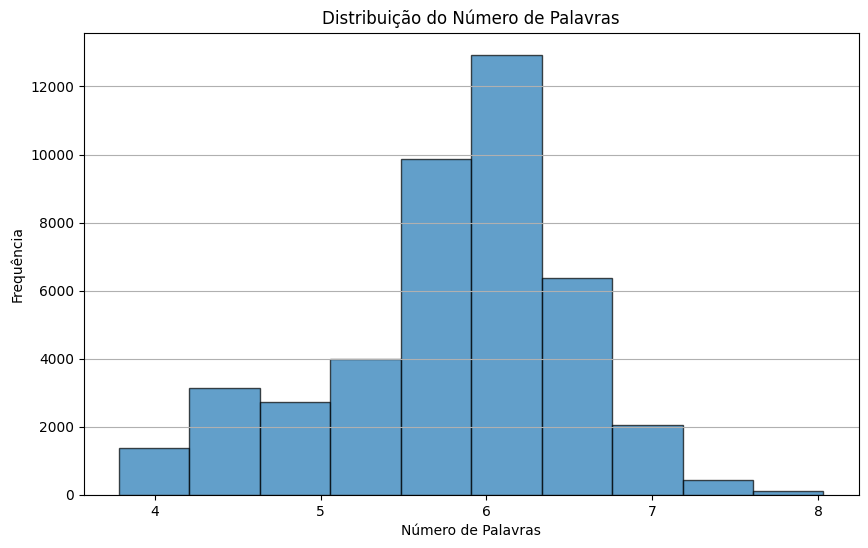

In [53]:
plt.figure(figsize=(10, 6))
plt.hist(np.log(df['num_of_words']), bins=10, edgecolor='black', alpha=0.7)
plt.title('Distribuição do Número de Palavras')
plt.xlabel('Número de Palavras')
plt.ylabel('Frequência')
plt.grid(axis='y')
plt.show()

## Boxplot representando o número de palavras

O boxplot mostra a distribuição do número de palavras em textos após uma transformação logarítmica. A mediana é cerca de 6, sugerindo que a maioria dos textos tem em torno de 6 palavras. A caixa do boxplot, entre o primeiro e terceiro quartil, indica que 50% dos textos possuem entre aproximadamente 5 e 6,5 palavras. Os "whiskers" indicam a variação esperada dos dados até 1,5 vezes o intervalo interquartil (IQR). Além disso, há outliers representando textos muito curtos (menos de 4 palavras) ou muito longos (mais de 7 palavras). Em síntese, a análise revela que a maioria dos textos tem um número moderado de palavras, com a predominância de textos de comprimento médio, sendo textos extremamente curtos ou longos menos frequentes.

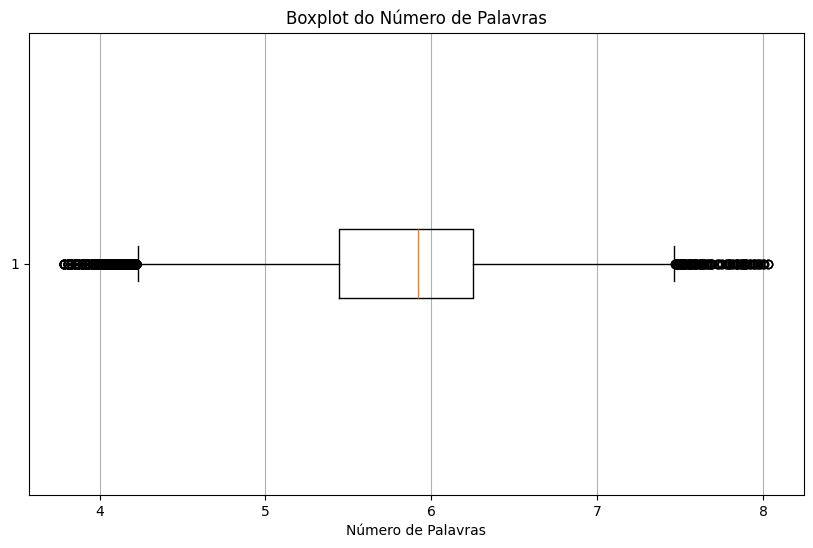

In [54]:
# Boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(np.log(df['num_of_words']), vert=False)
plt.title('Boxplot do Número de Palavras')
plt.xlabel('Número de Palavras')
plt.grid(axis='x')
plt.show()

## Gráfico de barras comparando o número de notícias falsas vs verdadeiras por ano

O gráfico abaixo compara o número de notícias falsas e verdadeiras publicadas anualmente de 2015 a 2018. 
As conclusões são:

2015: Poucas notícias, com ligeira predominância das falsas.
2016: Aumento significativo de notícias, com mais falsas do que verdadeiras.
2017: Pico de notícias, com um aumento expressivo em ambas as categorias, sendo as verdadeiras consideravelmente mais numerosas.
2018: Poucas notícias, tanto falsas quanto verdadeiras, indicando baixa coleta de dados ou atividade mínima.

Em resumo, o período de 2016 a 2017 registrou um aumento acentuado na produção ou coleta de notícias, com destaque para 2017, especialmente para as notícias verdadeiras.

In [55]:
date_formats = ['%B%d,%Y', '%d-%b-%y', '%B%d,%Y', '%b%d,%Y', '%d-%b-%Y', '%d%B%Y', '%d%b%Y', '%Y-%m-%d', '%m-%d-%Y', '%Y/%m/%d', '%B%d,%Y', '%B%d,%Y', '%B%d,%Y', '%B%d,%Y']

def is_valid_date(date_str):
    for format_str in date_formats:
        try:
            return pd.to_datetime(re.sub(r'\s+', '', str(date_str)), format=format_str)
        except ValueError:
            pass

    return pd.NaT

valid_dates = df.copy()
valid_dates['date'] = valid_dates['date'].map(is_valid_date)
valid_dates['year'] = valid_dates['date'].dt.year

<Figure size 1200x600 with 0 Axes>

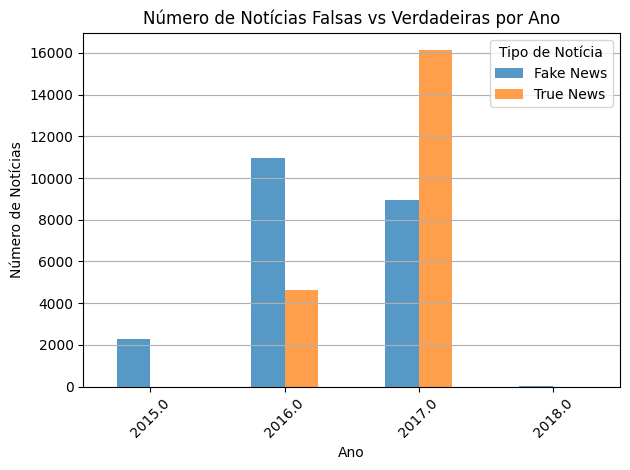

In [56]:
# Contar o número de notícias falsas e verdadeiras por ano
fake_news_per_year = valid_dates[valid_dates['label'] == 0].groupby('year').size()
true_news_per_year = valid_dates[valid_dates['label'] == 1].groupby('year').size()

# Criar um DataFrame com esses dados
news_counts_per_year = pd.DataFrame({
    'Fake News': fake_news_per_year,
    'True News': true_news_per_year
}).fillna(0)  # Preencher valores ausentes com 0

# Plotar o gráfico
plt.figure(figsize=(12, 6))
news_counts_per_year.plot(kind='bar', stacked=False, alpha=0.75)
plt.title('Número de Notícias Falsas vs Verdadeiras por Ano')
plt.xlabel('Ano')
plt.ylabel('Número de Notícias')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Notícia')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

## Gráfico de Similaridade em Notícias Verdadeiras, Falsas e Mistas

### Descrição dos Gráficos de Similaridade em Notícias Verdadeiras, Falsas e Mistas

O gráfico compara a similaridade das notícias falsas, verdadeiras e mistas em relação aos subjects "worldnews" e "politics". A similaridade é representada pela distância média (quanto menor a distância, maior a similaridade).

### Análise

- Fake vs Fake: Notícias falsas têm uma similaridade moderada, com uma distância média em torno de 20.
- True vs True: Notícias verdadeiras têm a menor similaridade, com a maior distância média, ligeiramente acima de 20.
- True vs Fake: Notícias mistas têm a maior similaridade, com a menor distância média, aproximadamente 15.

### Conclusão

As notícias mistas (verdadeiras vs falsas) mostram maior similaridade entre si, indicando que as notícias verdadeiras e falsas compartilham características comuns. As notícias verdadeiras mantêm menor similaridade quando comparadas entre si, enquanto as notícias falsas também têm uma similaridade moderada dentro do seu grupo.

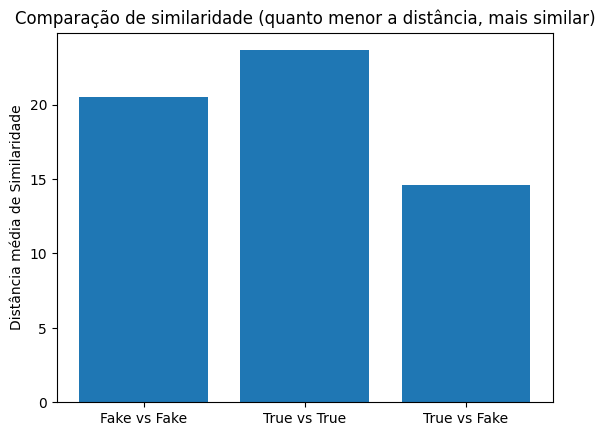

In [116]:
# Calculando as médias das similaridades
labels = ['Fake vs Fake', 'True vs True', 'True vs Fake']
similarities = [np.mean(fake_vs_fake_similarities), np.mean(true_vs_true_similarities), np.mean(true_vs_fake_similarities)]

# Plotando as similaridades
plt.bar(labels, similarities)
plt.ylabel('Distância média de Similaridade')
plt.title('Comparação de similaridade (quanto menor a distância, mais similar)')
plt.show()

# Teste de hipótese

## Teste de Hipótese: Similaridade entre Notícias Verdadeiras, Falsas e Mistas

Neste notebook, realizaremos um teste de hipótese para comparar a similaridade entre notícias verdadeiras, falsas e mistas. A similaridade é medida pela distância média (quanto menor a distância, maior a similaridade). O objetivo é determinar se há uma diferença significativa na similaridade entre as diferentes categorias de notícias.

### Passos do Teste de Hipótese

#### Definir Hipóteses:

- \(H_0\) (Hipótese Nula): Não há diferença significativa na similaridade entre as diferentes categorias de notícias.
- \(H_a\) (Hipótese Alternativa): Há uma diferença significativa na similaridade entre as diferentes categorias de notícias.

#### Calcular as Distâncias Médias:

- Obter as distâncias médias para cada categoria: Fake vs Fake, True vs True, e True vs Fake.

#### Realizar Teste de Hipótese:

- Usar o teste t de Student para comparar as distâncias médias entre as categorias.

#### Analisar os Resultados:

- Interpretar os valores p para determinar se rejeitamos ou não a hipótese nula.

## Resultados dos Testes de Hipótese

Os resultados dos testes para comparar as similaridades entre as diferentes categorias de notícias são os seguintes:

### Teste entre Fake vs Fake e True vs True:

- T-statistic: -16.37274849962382
- P-value: 1.6354346712162612e-56
- Conclusão: Rejeitamos a hipótese nula. Há uma diferença significativa na similaridade entre Fake vs Fake e True vs True.
- Observação: O resultado é altamente significativo (p < 0.01).

### Teste entre Fake vs Fake e True vs Fake:

- T-statistic: 25.650055569958536
- P-value: 1.199788220568109e-125
- Conclusão: Rejeitamos a hipótese nula. Há uma diferença significativa na similaridade entre Fake vs Fake e True vs Fake.
- Observação: O resultado é altamente significativo (p < 0.01).

### Teste entre True vs True e True vs Fake:

- T-statistic: 44.84103110401803
- P-value: 2.239345677091325e-302
- Conclusão: Rejeitamos a hipótese nula. Há uma diferença significativa na similaridade entre True vs True e True vs Fake.
- Observação: O resultado é altamente significativo (p < 0.01).


In [140]:
def perform_t_test(sample1, sample2, label1, label2):
    t_stat, p_value = ttest_ind(sample1, sample2, equal_var=False)
    print(f"Teste t de Student entre {label1} e {label2}:")
    print(f"T-statistic: {t_stat}")
    print(f"P-value: {p_value}\n")
    
    # Interpretação dos resultados
    alpha = 0.05  # Nível de significância de 5%
    if p_value < alpha:
        print(f"Resultado: Rejeitamos a hipótese nula. Há uma diferença significativa na similaridade entre {label1} e {label2}.")
    else:
        print(f"Resultado: Não rejeitamos a hipótese nula. Não há diferença significativa na similaridade entre {label1} e {label2}.")

    # Detalhes adicionais para interpretação
    if p_value < 0.01:
        print("Observação: O resultado é altamente significativo (p < 0.01).")
    elif p_value < 0.05:
        print("Observação: O resultado é estatisticamente significativo (p < 0.05).")
    else:
        print("Observação: O resultado não é estatisticamente significativo (p >= 0.05).")

    print("\n" + "-"*50 + "\n")

# Realizando os testes de hipótese
cropped_sample_fake_vs_fake = random.sample(fake_vs_fake_similarities, 1000)
cropped_sample_true_vs_true = random.sample(true_vs_true_similarities, 1000)
cropped_sample_true_vs_fake = random.sample(true_vs_fake_similarities, 1000)

perform_t_test(cropped_sample_fake_vs_fake, cropped_sample_true_vs_true, 'Fake vs Fake', 'True vs True')
perform_t_test(cropped_sample_fake_vs_fake, cropped_sample_true_vs_fake, 'Fake vs Fake', 'True vs Fake')
perform_t_test(cropped_sample_true_vs_true, cropped_sample_true_vs_fake, 'True vs True', 'True vs Fake')

Teste t de Student entre Fake vs Fake e True vs True:
T-statistic: -16.37274849962382
P-value: 1.6354346712162612e-56

Resultado: Rejeitamos a hipótese nula. Há uma diferença significativa na similaridade entre Fake vs Fake e True vs True.
Observação: O resultado é altamente significativo (p < 0.01).

--------------------------------------------------

Teste t de Student entre Fake vs Fake e True vs Fake:
T-statistic: 25.650055569958536
P-value: 1.199788220568109e-125

Resultado: Rejeitamos a hipótese nula. Há uma diferença significativa na similaridade entre Fake vs Fake e True vs Fake.
Observação: O resultado é altamente significativo (p < 0.01).

--------------------------------------------------

Teste t de Student entre True vs True e True vs Fake:
T-statistic: 44.84103110401803
P-value: 2.239345677091325e-302

Resultado: Rejeitamos a hipótese nula. Há uma diferença significativa na similaridade entre True vs True e True vs Fake.
Observação: O resultado é altamente significativo (

## Teste Qui-Quadrado para Proporção de Notícias Falsas em Textos Curtos e Longos

O código abaixo realiza um teste qui-quadrado de contingência para avaliar a proporção de notícias falsas em textos curtos (com menos de 150 palavras) e longos (com 150 palavras ou mais). Após dividir as notícias em categorias com base no comprimento, são calculadas as proporções de notícias falsas e verdadeiras em cada categoria. O teste estatístico é realizado e o resultado é exibido, mostrando a estatística Qui-Quadrado (Chi2) e o valor P associado. No caso específico deste teste, em que o resultado foi: Chi2 statistic: 2153.80, P-value: 0.00000, conclui-se que há uma diferença estatisticamente significativa na proporção de notícias falsas entre textos curtos e longos. Isso sugere que a probabilidade de uma notícia ser falsa está associada ao comprimento do texto. As proporções de notícias falsas e verdadeiras são exibidas para ambas as categorias, e é destacado que é mais provável que um texto longo seja uma notícia falsa em comparação a um texto curto, enquanto é mais provável que um texto curto seja uma notícia verdadeira em comparação a um texto longo.

In [179]:
from scipy.stats import chi2_contingency

# Dividir as notícias em curtas e longas
short_texts = new_df[new_df['num_of_words'] < 150]
long_texts = new_df[new_df['num_of_words'] >= 150]

# Calcular a proporção de notícias falsas e verdadeiras em cada categoria
short_fake_count = short_texts[short_texts['label'] == 0].shape[0]
short_true_count = short_texts[short_texts['label'] == 1].shape[0]
long_fake_count = long_texts[long_texts['label'] == 0].shape[0]
long_true_count = long_texts[long_texts['label'] == 1].shape[0]

short_fake_proportion = short_fake_count / short_texts.shape[0]
short_true_proportion = short_true_count / short_texts.shape[0]
long_fake_proportion = long_fake_count / long_texts.shape[0]
long_true_proportion = long_true_count / long_texts.shape[0]

# Preparar os dados para o teste qui-quadrado de contingência
contingency_table = pd.DataFrame({
    'Short Texts': [short_fake_count, short_true_count],
    'Long Texts': [long_fake_count, long_true_count]
}, index=['Fake', 'True'])

# Realizar o teste qui-quadrado de contingência
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi2 statistic: {chi2:.2f}, P-value: {p:.5f}")

if p < 0.05:
    print("Há uma diferença estatisticamente significativa na proporção de notícias falsas entre textos curtos e longos. "
          "Isso sugere que a probabilidade de uma notícia ser falsa está associada ao comprimento do texto.")

    print(f"Proporção de notícias falsas entre textos curtos: {short_fake_proportion:.2%}")
    print(f"Proporção de notícias verdadeiras entre textos curtos: {short_true_proportion:.2%}")
    print(f"Proporção de notícias falsas entre textos longos: {long_fake_proportion:.2%}")
    print(f"Proporção de notícias verdadeiras entre textos longos: {long_true_proportion:.2%}")

    if short_fake_proportion > long_fake_proportion:
        print("É mais provável que um texto curto seja uma notícia falsa comparado a um texto longo.")
    else:
        print("É mais provável que um texto longo seja uma notícia falsa comparado a um texto curto.")

    if short_true_proportion > long_true_proportion:
        print("É mais provável que um texto curto seja uma notícia verdadeira comparado a um texto longo.")
    else:
        print("É mais provável que um texto longo seja uma notícia verdadeira comparado a um texto curto.")
else:
    print("Não há uma diferença estatisticamente significativa na proporção de notícias falsas entre textos curtos e longos. "
          "Isso sugere que a probabilidade de uma notícia ser falsa não está associada ao comprimento do texto.")

Chi2 statistic: 2153.80, P-value: 0.00000
Há uma diferença estatisticamente significativa na proporção de notícias falsas entre textos curtos e longos. Isso sugere que a probabilidade de uma notícia ser falsa está associada ao comprimento do texto.
Proporção de notícias falsas entre textos curtos: 26.27%
Proporção de notícias verdadeiras entre textos curtos: 73.73%
Proporção de notícias falsas entre textos longos: 56.57%
Proporção de notícias verdadeiras entre textos longos: 43.43%
É mais provável que um texto longo seja uma notícia falsa comparado a um texto curto.
É mais provável que um texto curto seja uma notícia verdadeira comparado a um texto longo.
